In [1]:
%pylab nbagg
%matplotlib inline
from tvb.simulator.lab import *
import os.path
from matplotlib import colors, cm
import time
import scipy.signal as sig

import numpy as np
import pandas as pd
import scipy.io

# downloaded library for peak detection in z time series
import peakdetect
from runmainsim import *
import tvbsim

import re
import sys
sys.path.append('/Users/adam2392/Documents/fragility_analysis/')
import fragility.signalprocessing as sp

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [22]:
# patient = 'id002_cj'
patient = 'id001_ac'
patient = 'id002_cj'
patient = 'id014_rb'

# get the cortical surface meta data
metadatadir = os.path.join("/Users/adam2392/Documents/tvb/metadata/", patient)
cort_surf = surfaces.CorticalSurface.from_file(source_file=os.path.join(metadatadir, "surface_cort.zip"))
cort_surf.configure()
display(cort_surf.summary_info)

# read in seeg file
seeg = pd.read_csv(os.path.join(metadatadir, "seeg.txt"), names=['x', 'y', 'z'], delim_whitespace=True)
seeg_labels = seeg.index
seeg_xyz = seeg.as_matrix()

{'Edge lengths, longest (mm)': 9.048596736349454,
 'Edge lengths, mean (mm)': 0.9476404090010739,
 'Edge lengths, shortest (mm)': 0.019807841603769128,
 'Has two hemispheres': False,
 'Number of edges': 1027914,
 'Number of triangles': 685276,
 'Number of vertices': 342642,
 'Surface type': 'CorticalSurface',
 'Valid for simulations': False}

In [23]:
eznum=1
pznum=0

# Set the directory and file to read
outputdir = os.path.join('/Users/adam2392/Documents/pydata/tvbforwardsim/movedcontacts', patient)
if not os.path.exists(outputdir):
    os.mkdir(outputdir)
filename = os.path.join(outputdir, patient+'_sim_nez'+str(eznum)+\
                                '_npz'+str(pznum)+'.npz')
# load simulated data
data = np.load(filename)

# extract data and metadata from simulation
epits = data['epits']
zts = data['zts']
times = data['times']
seegts = data['seegts']

metadata = data['metadata'].item()
seeg_labels = metadata['seeg_contacts']
seeg_xyz = metadata['seeg_xyz']
region_labels = metadata['regions']
region_centers = metadata['regions_centers']
ezregions = metadata['ez']
pzregions = metadata['pz']
ezindices = metadata['ezindices']
onsettimes = metadata['onsettimes']
offsettimes = metadata['offsettimes']

print filename
# print findonsetoffset(zts[ezindices,:])
print data.keys()
print "Meta data contains: ", metadata.keys()
print "ez indices: ", metadata['ezindices']
print "ez region: ", ezregions
print "pz indices: ", metadata['pzindices']
print "pz region: ", pzregions

postprocessor = tvbsim.util.PostProcess(epits, seegts, times)
if eznum > 0:
    onsettimes, offsettimes = postprocessor.findonsetoffset(zts[ezindices, :].squeeze(), delta=0.2)
else:
    onsettimes = []
    offsettimes = []
    
# initialize object to assist in moving seeg contacts
movecontact = tvbsim.util.MoveContacts(seeg_labels, seeg_xyz, 
                                       region_labels, region_centers, True)
ezseegindex = []
for ezindex in ezindices:
    print "Moving onto current ez index: ", ezindex, " at ", region_labels[ezindex]
    # find the closest contact index and distance
    ezseegindex, distance = movecontact.findclosestcontact(ezindex)
    
    print ezseegindex, distance
    print seeg_labels[ezseegindex]

ezseegindex = [ezseegindex]

# initialize dsp object to perform dsp fitlering
# dspobject = sp.filters.SignalProcessing(seegts)
# seegts = dspobject.filterrawdata(freqrange=[59.5, 60.5], )

/Users/adam2392/Documents/pydata/tvbforwardsim/movedcontacts/id014_rb/id014_rb_sim_nez1_npz0.npz
['metadata', 'zts', 'seegts', 'epits', 'times']
Meta data contains:  ['patient', 'pz', 'onsettimes', 'seeg_xyz', 'x0ez', 'regions_centers', 'regions', 'seeg_contacts', 'offsettimes', 'x0pz', 'ez', 'pzindices', 'x0norm', 'ezindices']
ez indices:  [0]
ez region:  ['ctx-lh-bankssts']
pz indices:  []
pz region:  []
Moving onto current ez index:  0  at  ctx-lh-bankssts
72 0.0
H'13


In [24]:
elect = []
dipole = []

# create lists of elect and dipoles
for element in range(0,seeg.shape[0]):
    kpm = np.array(re.match("([A-Z]+[a-z]*[']*)([0-9]+)", seeg_labels[element]).groups())
    elect.append(kpm[0])
    dipole.append(int(kpm[1]))

'''
Descrip: 
- Number of electrodes is : len(find_0)
- Number of contacts per an electrode i is nbr_contacts[i+1]

''' 
# find the beginning index of each electrode
find_0 = []
nbr_contacts = []
for element_1 in range(0, len(dipole)):
    if dipole[element_1] == 1:
        find_0.append(element_1)
for element_2 in range(0, len(find_0)-1):
    nbr_contacts.append(find_0[element_2+1]-find_0[element_2])
nbr_contacts.append(len(seeg_labels)- find_0[len(find_0)-1])

# Find the list of the ending index of each electrode
incr_cont = np.zeros((len(nbr_contacts)), dtype=int)
incr_cont[0] = 0

for element_4 in range(0, len(nbr_contacts)):
    incr_cont[element_4] = incr_cont[element_4-1] + nbr_contacts[element_4]

    
print "Nbre_contacts_per_electrode:", nbr_contacts
print "Nbre_electrodes:", len(nbr_contacts)
print "Ending Index of electrodes:", incr_cont # To plot each electrode with diff color

print sum(nbr_contacts) # to be sure that the code is correct
print len(seeg_labels)

Nbre_contacts_per_electrode: [15, 15, 15, 15, 15, 15, 15, 15, 15, 10, 10, 10]
Nbre_electrodes: 12
Ending Index of electrodes: [ 15  30  45  60  75  90 105 120 135 145 155 165]
165
165


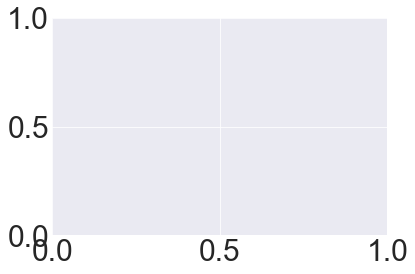

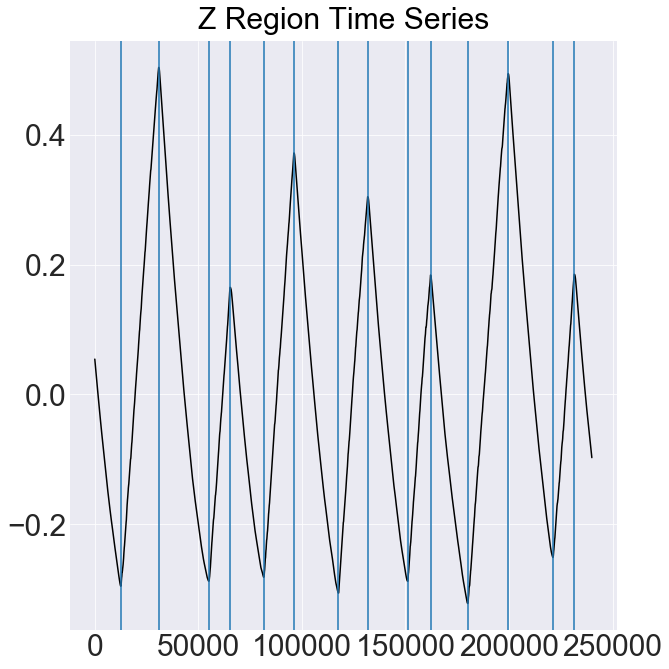

ezreion is:  ['ctx-lh-bankssts']
pzregion is:  []
x0 values are (ez, pz, norm):  -1.6 -2.04 -2.5
time series shape is:  (84, 240000)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83]
here: [ 0 73 68 52]
[ 0 73 68 52]
[ 5.66120958  2.41368306  2.43603702  2.47046053  2.44696522  2.41384421
  2.43695136  2.42532659  2.46481215  2.54936128  2.54730052  2.46401864
  2.40165322  2.36867251  2.51810597  2.44914178  2.4422154   2.4612223
  2.39526516  2.50669131  2.48620251  2.38454302  2.41350815  2.41274316
  2.47509073  2.49727377  2.42784768  2.40008978  2.4648801   2.37655311
  2.44729768  2.45313064  2.46054839  2.49213819  2.39971905  2.46160862
  2.33834165  2.47900652  2.43383664  2.40221992  2.37553596  2.37312835
  2.39363469  2.41811767  2.44702162  2.44565105  2.36368423  2.47

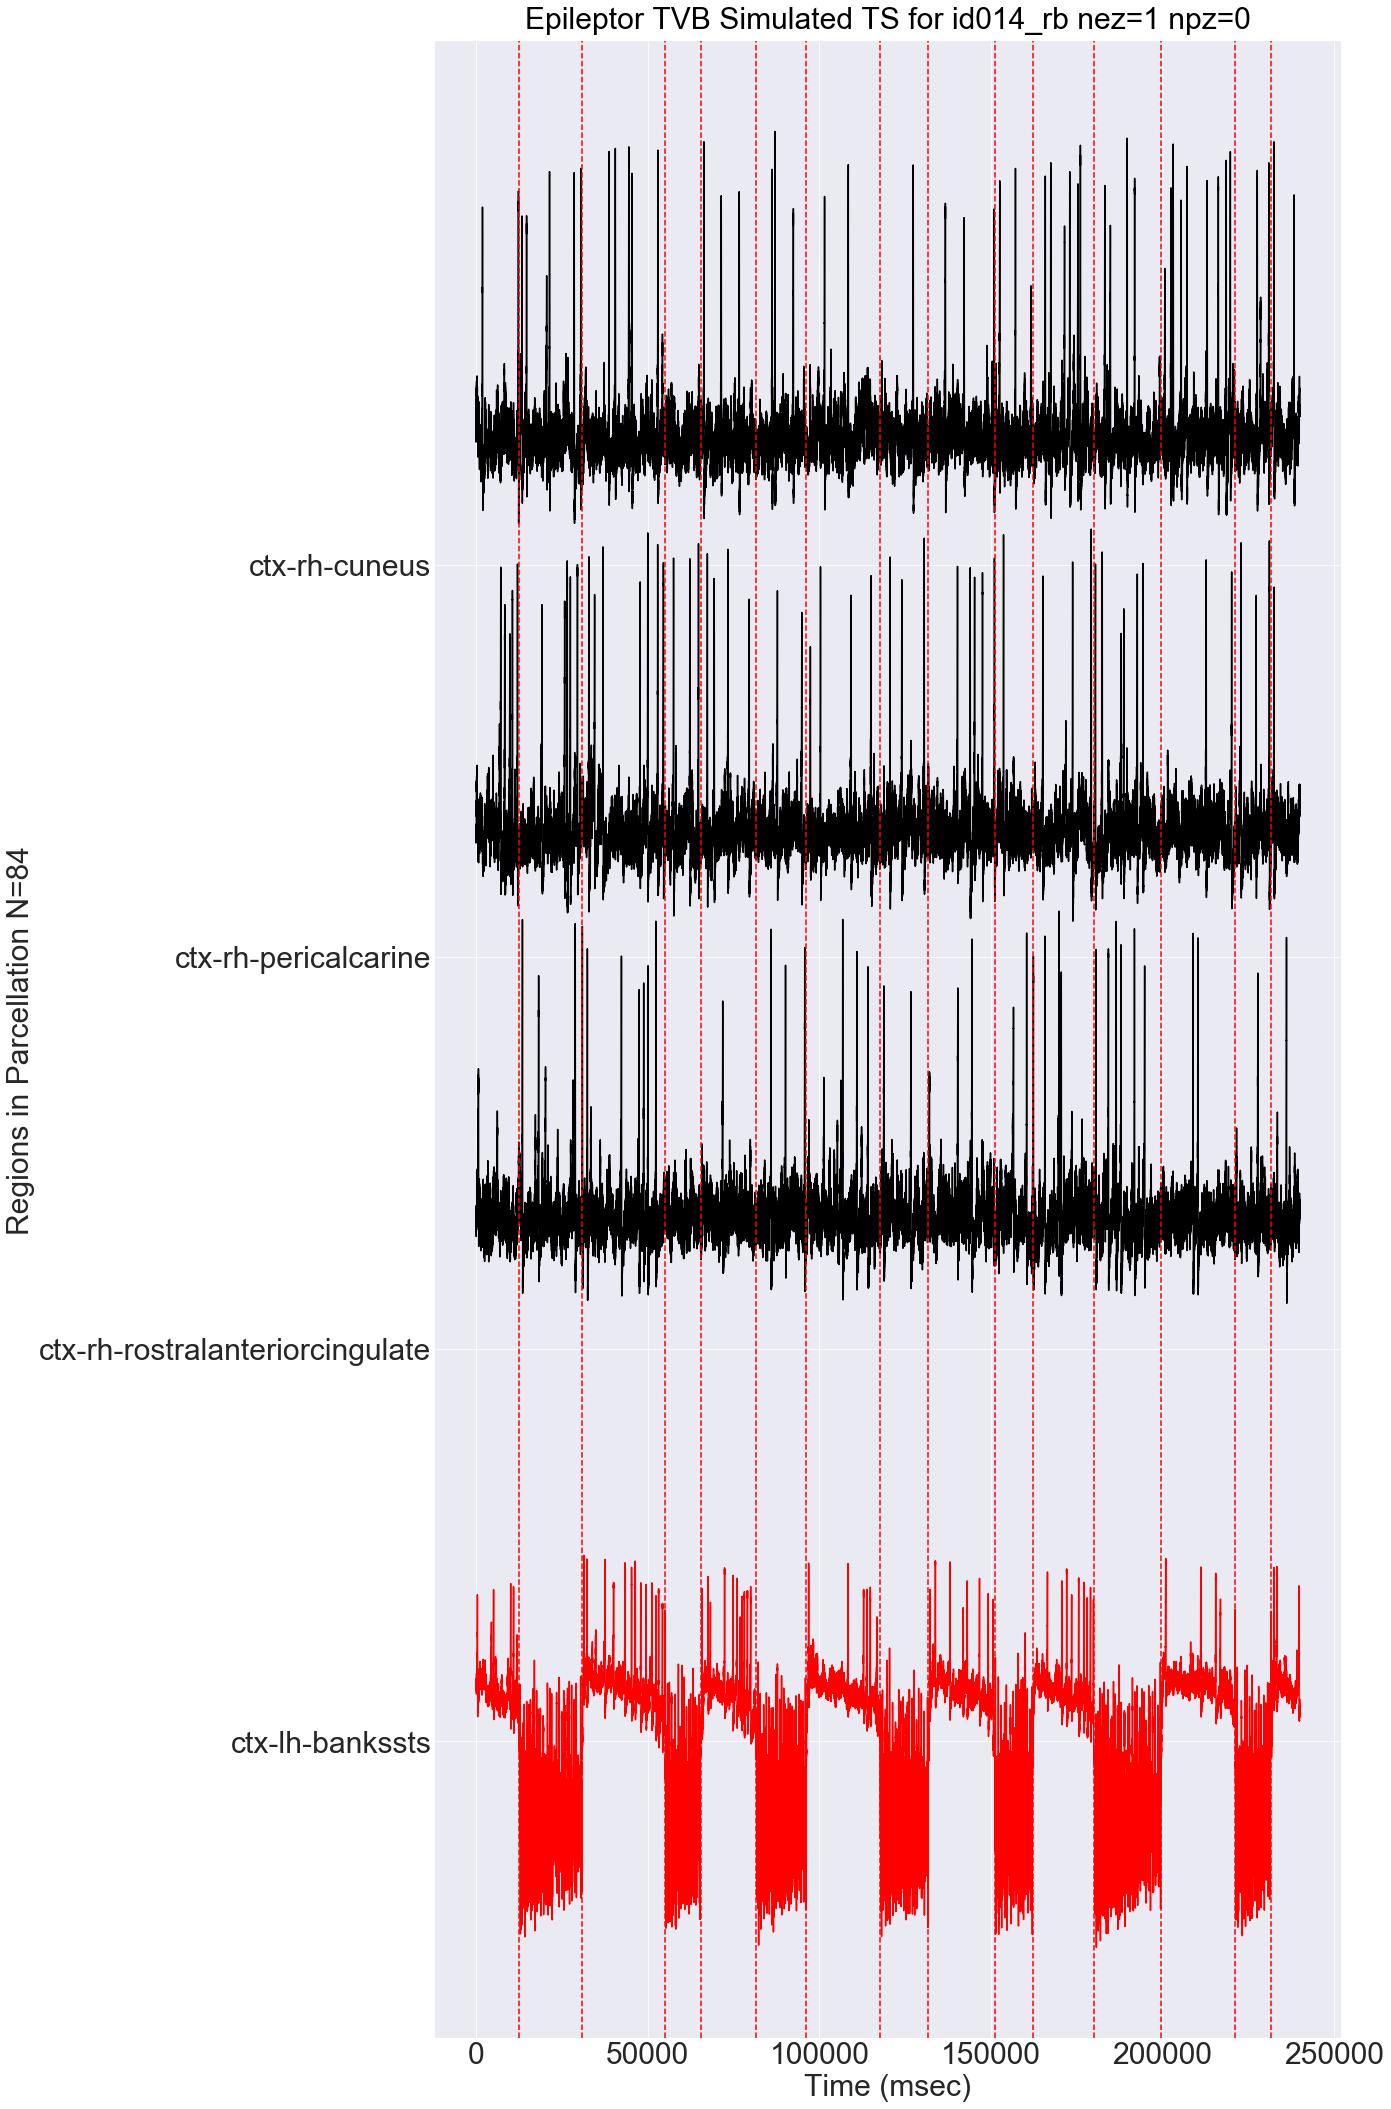

In [25]:
### Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'30', 'color':'black', 'weight':'normal',
          'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'family':'Arial', 'size':'30'}

color_new = ['peru', 'dodgerblue', 'slategrey', 
             'skyblue', 'springgreen', 'fuchsia', 'limegreen', 
             'orangered',  'gold', 'crimson', 'teal', 'blueviolet', 'black', 'cyan', 'lightseagreen',
             'lightpink', 'red', 'indigo', 'mediumorchid', 'mediumspringgreen']

rawplotter = tvbsim.visualize.RawPlotter(axis_font, title_font, color_new)
rawplotter.initializefig(figsize=(10,10))
for ezindex in ezindices:
    zfig = rawplotter.plotzts(zts[ezindex,:]-np.mean(zts[ezindex,:]), ezindex, list(onsettimes), list(offsettimes))
    
rawplotter.initializefig(figsize=(20,30))
epifig = rawplotter.plotepileptorts(epits, times, metadata, patient, onsettimes, offsettimes, plotsubset=True)

ezreion is:  ['ctx-lh-bankssts']
pzregion is:  []
x0 values are (ez, pz, norm):  -1.6 -2.04 -2.5
time series shape is:  (84, 240000)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83]
here: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83]
[ 5.66120958  2.41368306  2.43603702  2.47046053  2.44696522  2.41384421
  2.43695136  2.4

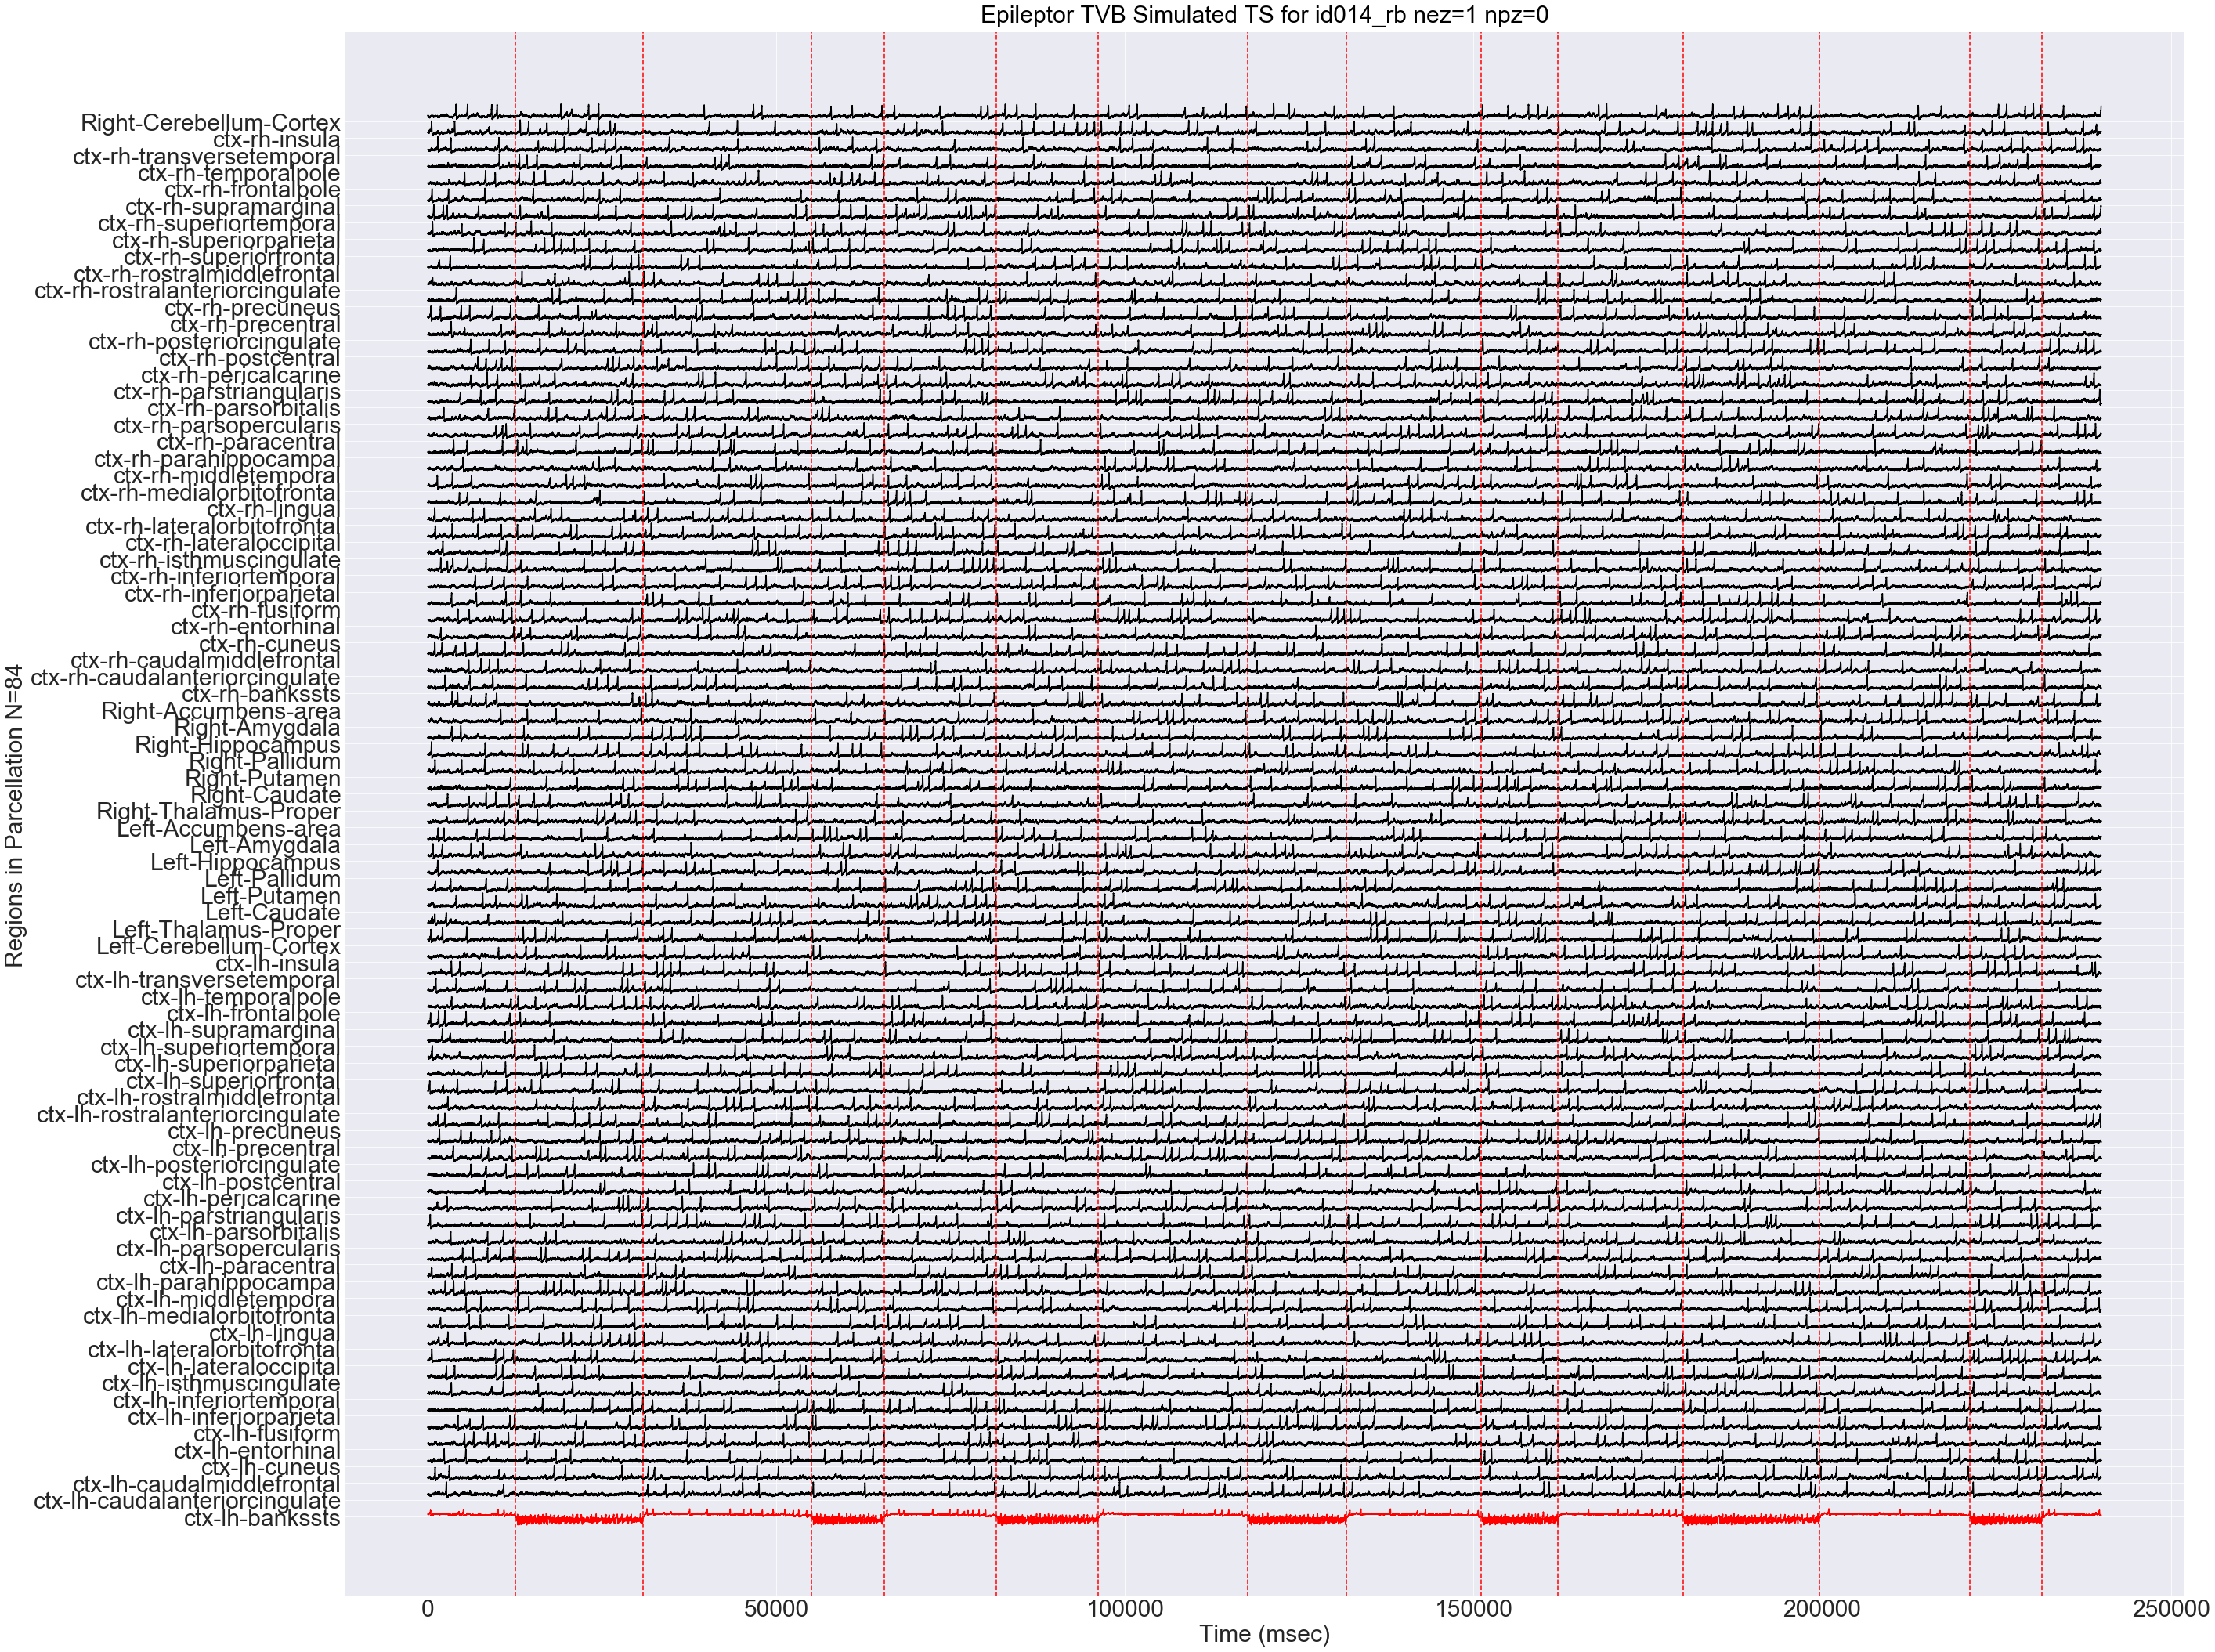

In [26]:
rawplotter.initializefig(figsize=(40,30))
epifig = rawplotter.plotepileptorts(epits, times, metadata, patient, onsettimes, offsettimes, plotsubset=False)

In [27]:
# perform filtering on raw SEEG before visualizing
filteredseegts = tvbsim.visualize.highpassfilter(seegts)
# dspobject = sp.filters.SignalProcessing(filteredseegts)
# filteredseegts = dspobject.filterrawdata(freqrange=[59.5, 60.5], )

ez seeg index is:  [72]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164]
here: [  72.   29.   14.  111.]
[  99.28605557   70.68707895   64.02864415   63.72915189   61.02820734
   46.25956417   44.78585284   48.29615825   61.79933518   69.80040184
   76.14468791   84.42711989   91.43348529   85.60120074   64.56036245
   78.46661192   76.65489585   56.45911104   51.24682357   5

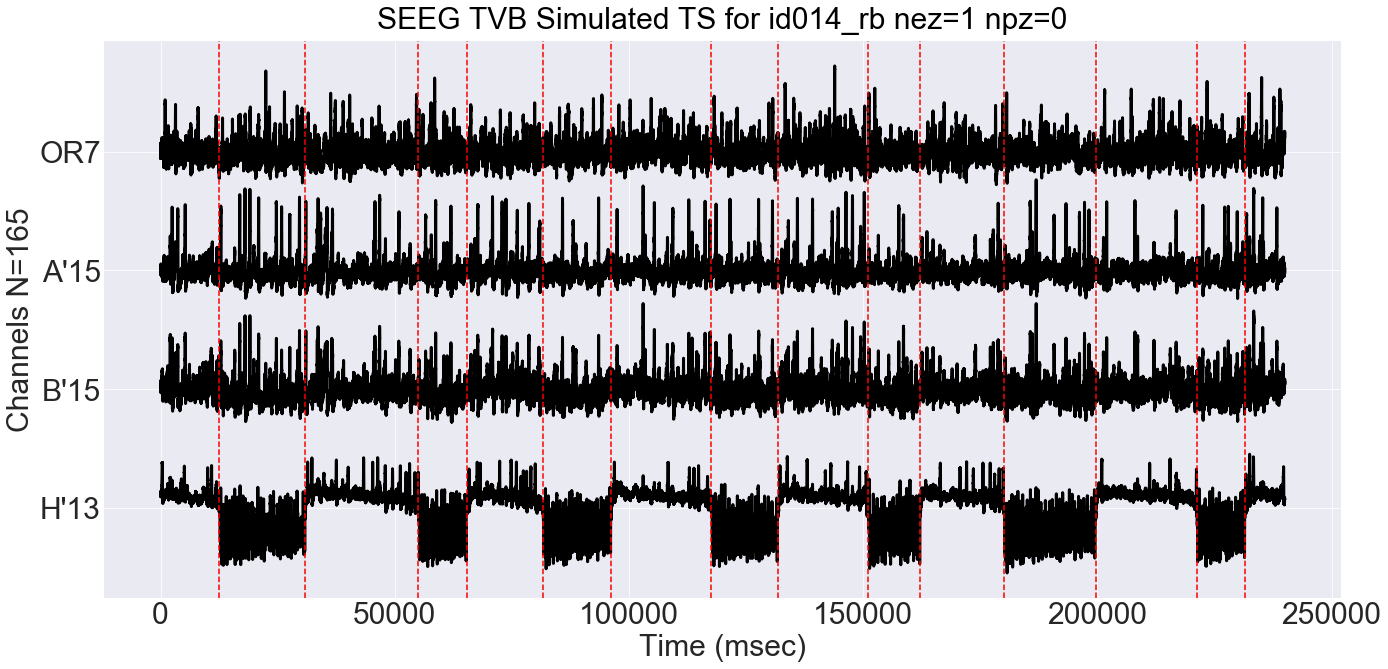

In [28]:
# ezseegindex = []
rawplotter.initializefig(figsize=(20, 10))
seegfig = rawplotter.plotseegts(seegts, times, metadata, onsettimes, offsettimes, patient, ezseegindex, plotsubset=True)

# rawplotter.initializefig(figsize=(40, 20))
# seegfig = rawplotter.plotseegts(filteredseegts, times, metadata, onsettimes, offsettimes, patient, ezseegindex, plotsubset=False)

num regions:  84
num contacts:  165
12
xreg:  (84,)
yreg:  (84,)
zreg:  (84,)
[0]
[]


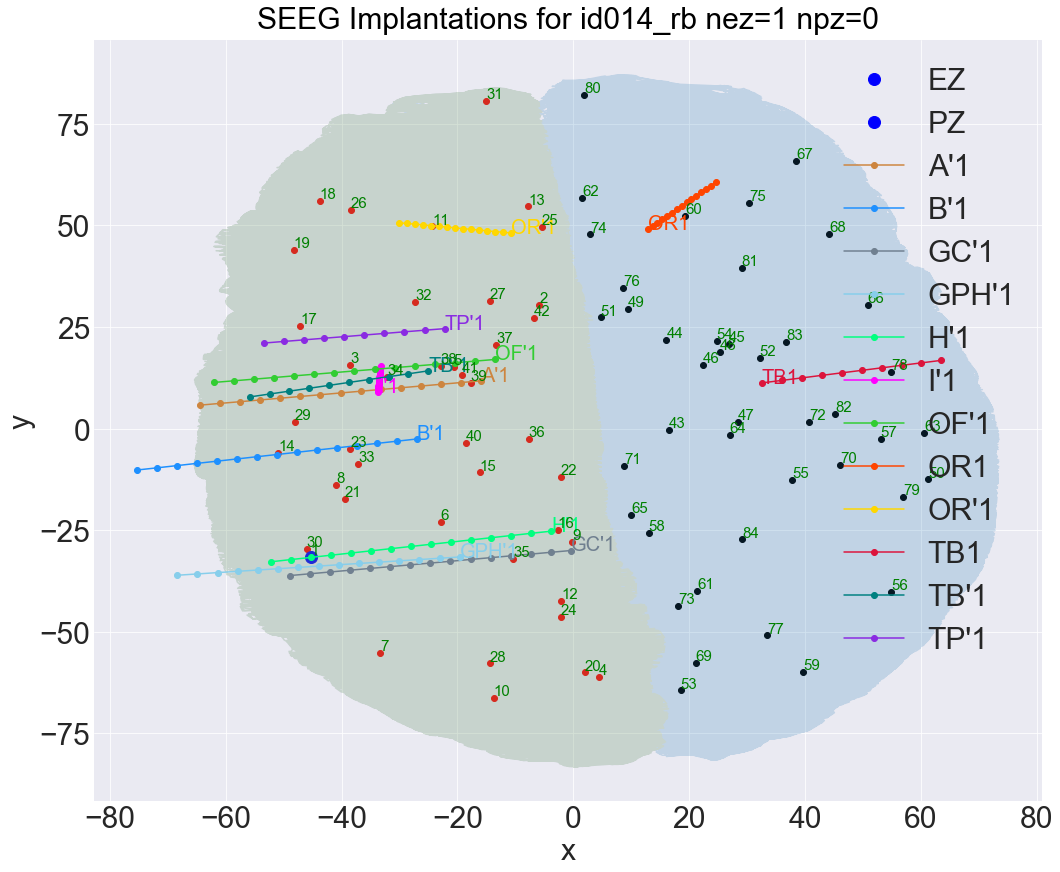

In [29]:
# rawplotter = tvbsim.visualize.RawPlotter()
rawplotter.initializefig(figsize=(17,14))
brainfig = rawplotter.plotcontactsinbrain(cort_surf, region_centers, region_labels, seeg_xyz, seeg_labels, incr_cont, patient, ezindices, pzindices=[])

figfile = os.path.join('/Users/adam2392/Documents/pydata/figures/',
            patient+'_sim_nez'+str(eznum)+'_npz'+str(pznum) + '_brainhemis.pdf')
brainfig.savefig(figfile, bbox_inches='tight')

In [14]:
brainfig = rawplotter.fig
print brainfig
# print rawplotter.axes
brainfig.savefig(figfile, bbox_inches='tight')

Figure(1224x1008)
